## Unsupervised Learning: PCA
* In this exercise, we will analyze the same P300 data set but now with the most commonly used unsupervised learning method: principal components analysis (PCA).
* The Singular Value Decomposition (SVD) provides a convenient way of performing PCA
* We will decompose the EEG into both spatial and temporal bases
* Once we obtain the learned components, we will use them as features into a supervised learning problem. 

### Load in the data and extract the training and test sets

In [84]:
filename = '../data/P300.mat' # the data file
import scipy.io as sio # the library that we use to load Matlab data into Python
data = sio.loadmat(filename)
x_train = data['X_train']
x_test = data['X_test']
y_train = data['Y_train']
y_test = data['Y_test']

### Rearrange training data to two-dimensions for Singular Value Decomposition

In [85]:
print("original data:")
print(x_train.shape)
x_train_ = np.swapaxes(x_train,0,1)
x_train_ = np.swapaxes(x_train_,1,2)
print("reshaped data:")
print(x_train_.shape)

original data:
(1058, 64, 128)
reshaped data:
(64, 128, 1058)


### Combine the time and trial dimensions

In [66]:
x_train_ = np.reshape(x_train_,(x_train_.shape[0],x_train_.shape[1]*x_train_.shape[2])) 
print("combined data:")
print(x_train_.shape)

combined data:
(64, 135424)


### Apply the SVD

In [5]:
u,s,vh=np.linalg.svd(x_train_,full_matrices=False)

### Inspect the singular value "spectrum"

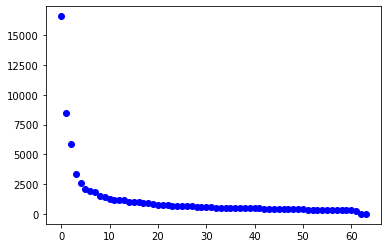

In [68]:
import matplotlib.pyplot as plt
plt.plot(s, 'bo')
plt.show()

### The knee point occurs somewhere 7-8 components

### Reshape SVD output back to 3D

In [72]:
n_samples = x_train.shape[2]
n_examples = x_train.shape[0]
vh_3d = np.reshape(vh,(vh.shape[0],n_samples,n_examples)) 
print(vh_3d.shape)

(64, 128, 1058)


### In vh_3d, the first dimension is _component_, not electrode

### Inspect the mean time course of the first four components

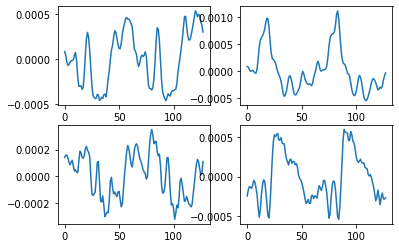

In [73]:
evoked_response = np.mean(vh_3d,axis=2) # average across trials
fig, ax = plt.subplots(2, 2)
ax[0,0].plot(evoked_response[0,:].T)
ax[0,1].plot(evoked_response[1,:].T)
ax[1,0].plot(evoked_response[2,:].T)
ax[1,1].plot(evoked_response[3,:].T)
plt.show()

### Inspect the spatial topographies of the components
* We will use the MNE package 

In [74]:
import mne
biosemi_montage = mne.channels.make_standard_montage('biosemi64')
biosemi_info = mne.create_info(ch_names=biosemi_montage.ch_names, sfreq=64, ch_types='eeg')
evoked = mne.EvokedArray(u, biosemi_info) 
evoked.set_montage(biosemi_montage)
montage_head = evoked.get_montage()
fake_times = evoked.times

### Plot the spatial topographies

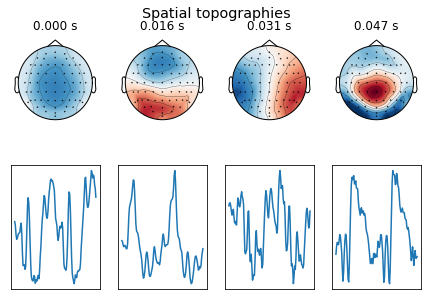

In [11]:
comp_idx=np.arange(4)
fig,ax=plt.subplots(2,4)

for i in comp_idx:
    ax[1,i].plot(evoked_response[i,:].T)
    ax[1,i].set_yticks([])
    ax[1,i].set_xticks([])

evoked.plot_topomap(fake_times[comp_idx],ch_type='eeg',time_unit='s',axes=ax[0,:], title='Spatial topographies', colorbar=False)

fig.tight_layout()
plt.show()

### Use the spatial filters as preprocessing for supervised learning
* The spatial filters learned by the SVD will reduce the dimensionality of the data
* Instead of 64 electrodes, we will be working with a smaller number of components or "virtual" electrodes
* Variable n_comp controls the number of components that we include

In [76]:
n_comp=7
w = u[:,0:n_comp] # using first n_comp components

x_train_new = np.swapaxes(x_train,1,2)@w  # @ denotes matrix multiplication
x_train_new = np.swapaxes(x_train_new,1,2)

x_test_new = np.swapaxes(x_test,1,2)@w
x_test_new = np.swapaxes(x_test_new,1,2)


### Set up the convolutional model
* We will use the same architecture as in the previous demo

In [80]:
import keras
input_shape=(n_comp,128,1) # here we are only using n_comp virtual channels
num_classes = 2
num_filters = 4
kernel_dur = 10 # of samples in convolution window
reg_l1_l2 = keras.regularizers.l1_l2(l1=0, l2=0) # no regularization due to reduced dimensionality
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Conv2D(num_filters, kernel_size=(n_comp, kernel_dur), activation="relu"),
        keras.layers.Flatten(),
        keras.layers.Dense(num_classes, activation="softmax", kernel_regularizer = reg_l1_l2),
    ]
)
model.summary()



Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 1, 119, 4)         284       
                                                                 
 flatten_11 (Flatten)        (None, 476)               0         
                                                                 
 dense_11 (Dense)            (None, 2)                 954       
                                                                 
Total params: 1,238
Trainable params: 1,238
Non-trainable params: 0
_________________________________________________________________


### Compile the model

In [81]:
batch_size = 128  # how many training examples in each "batch" used to compute gradient of loss function
epochs = 30 # how many passes through the data we want the fitting to take
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy",keras.metrics.AUC()])

### Fit the model with 30 epochs

In [82]:
model.fit(x_train_new, y_train, batch_size=batch_size, epochs=epochs)

Epoch 1/30
9/9 [==============================] - 0s 4ms/step - loss: 4.3554 - accuracy: 0.6002 - auc_11: 0.6255
Epoch 2/30
9/9 [==============================] - 0s 4ms/step - loss: 2.9509 - accuracy: 0.8251 - auc_11: 0.8382
Epoch 3/30
9/9 [==============================] - 0s 4ms/step - loss: 1.8319 - accuracy: 0.7713 - auc_11: 0.8194
Epoch 4/30
9/9 [==============================] - 0s 4ms/step - loss: 1.6676 - accuracy: 0.7117 - auc_11: 0.7722
Epoch 5/30
9/9 [==============================] - 0s 4ms/step - loss: 1.3154 - accuracy: 0.7902 - auc_11: 0.8475
Epoch 6/30
9/9 [==============================] - 0s 4ms/step - loss: 1.1357 - accuracy: 0.7892 - auc_11: 0.8509
Epoch 7/30
9/9 [==============================] - 0s 4ms/step - loss: 0.9996 - accuracy: 0.7968 - auc_11: 0.8512
Epoch 8/30
9/9 [==============================] - 0s 4ms/step - loss: 0.8838 - accuracy: 0.8119 - auc_11: 0.8678
Epoch 9/30
9/9 [==============================] - 0s 4ms/step - loss: 0.7908 - accuracy: 0.8261 

### Evaluate the model's performance

In [83]:
metrics = model.evaluate(x_test_new,y_test)
print("Model accuracy = " + str(metrics[1]))
print("Model AUROC = " + str(metrics[2]))

17/17 [==============================] - 0s 1ms/step - loss: 0.9711 - accuracy: 0.7811 - auc_11: 0.8491
Model accuracy = 0.7811321020126343
Model AUROC = 0.849104642868042
